In [62]:
# note Grakel does not seem to support Python >=3.10, Python 3.9 works fine
# you are free to remove imports that are not useful for you

#import sys
#!{sys.executable} -m pip install grakel
#!{sys.executable} -m pip install matplotlib
from grakel.datasets import fetch_dataset
from grakel.kernels import WeisfeilerLehman, VertexHistogram
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.decomposition import KernelPCA # to check your own implementation
from sklearn.manifold import TSNE
from matplotlib import pyplot as plot
import numpy as np
import scipy
import matplotlib.pyplot as plt
import math

In [74]:
# Some datasets, more datasets here https://ls11-www.cs.tu-dortmund.de/staff/morris/graphkerneldatasets
from ast import GtE
from grakel.kernels import ShortestPath
from grakel import Graph
"""
    The MUTAG dataset consists of 188 chemical compounds divided into two 
    classes according to their mutagenic effect on a bacterium. 

    The chemical data was obtained form http://cdb.ics.uci.edu and converted 
    to graphs, where vertices represent atoms and edges represent chemical 
    bonds. Explicit hydrogen atoms have been removed and vertices are labeled
    by atom type and edges by bond type (single, double, triple or aromatic).
    Chemical data was processed using the Chemistry Development Kit (v1.4).
"""

"""
    ENZYMES is a dataset of protein tertiary structures obtained from (Borgwardt et al., 2005) 
    consisting of 600 enzymes from the BRENDA enzyme database (Schomburg et al., 2004). 
    In this case the task is to correctly assign each enzyme to one of the 6 EC top-level 
    classes. 
"""

"""
    NCI1 and NCI109 represent two balanced subsets of datasets of chemical compounds screened 
    for activity against non-small cell lung cancer and ovarian cancer cell lines respectively
    (Wale and Karypis (2006) and http://pubchem.ncbi.nlm.nih.gov).
"""

dataset = fetch_dataset("MUTAG", verbose=False) # just replace by the name of the datasets you want "ENZYMES", "NCI1"
G = dataset.data
y = dataset.target

wl_kernel = WeisfeilerLehman(n_iter=10, normalize=True, base_graph_kernel=VertexHistogram)
#G_train, G_test, y_train, y_test = train_test_split(G, y, test_size=0.1, random_state=42)
#print(len(G_train))
#print(len(G_test))

K_train = wl_kernel.fit_transform(G)
print(K_train)

print(""+ str(np.linalg.matrix_rank(K_train)))

'''K_test = wl_kernel.transform(G)

clf = SVC(kernel='precomputed')
clf.fit(K_train, y_train)
SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale',
    kernel='precomputed', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

y_pred = clf.predict(K_test)
print("%2.2f %%" %(round(accuracy_score(y_test, y_pred)*100)))'''

[[1.         0.57509215 0.56413802 ... 0.55589197 0.71673825 0.64498003]
 [0.57509215 1.         0.5513308  ... 0.51454723 0.54701457 0.56085824]
 [0.56413802 0.5513308  1.         ... 0.52679836 0.53859896 0.57635157]
 ...
 [0.55589197 0.51454723 0.52679836 ... 1.         0.52197292 0.59571429]
 [0.71673825 0.54701457 0.53859896 ... 0.52197292 1.         0.61896063]
 [0.64498003 0.56085824 0.57635157 ... 0.59571429 0.61896063 1.        ]]
175


'K_test = wl_kernel.transform(G)\n\nclf = SVC(kernel=\'precomputed\')\nclf.fit(K_train, y_train)\nSVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,\n    decision_function_shape=\'ovr\', degree=3, gamma=\'scale\',\n    kernel=\'precomputed\', max_iter=-1, probability=False, random_state=None,\n    shrinking=True, tol=0.001, verbose=False)\n\ny_pred = clf.predict(K_test)\nprint("%2.2f %%" %(round(accuracy_score(y_test, y_pred)*100)))'

In [18]:
def center_K(K):
    len_K = len(K)
    N1 = np.full((len_K, len_K), 1/len_K)

    return (K -(N1 @ K) - (K @ N1) + (N1 @ K @ N1))
    
center_K(K_train)

array([[ 0.32560098, -0.01901717, -0.03049471, ..., -0.02065895,
         0.07185151,  0.00916546],
       [-0.01901717,  0.48618037,  0.03698777, ...,  0.01828601,
        -0.01758247,  0.00533337],
       [-0.03049471,  0.03698777,  0.48513356, ...,  0.03001373,
        -0.02652149,  0.02030329],
       ...,
       [-0.02065895,  0.01828601,  0.03001373, ...,  0.52129718,
        -0.02506571,  0.05774782],
       [ 0.07185151, -0.01758247, -0.02652149, ..., -0.02506571,
         0.38462555,  0.01265835],
       [ 0.00916546,  0.00533337,  0.02030329, ...,  0.05774782,
         0.01265835,  0.40276988]])

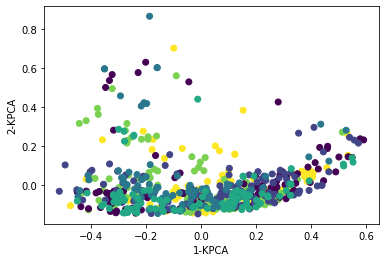

In [73]:
def display_KPCA(data):
    data = np.transpose(data)
    plot.scatter(data[0], data[1], c=y)
    plot.xlabel("1-KPCA")
    plot.ylabel("2-KPCA")
    plot.show()
    return

def kernel_PCA(K, dim):
    vals, vecs = np.linalg.eig(K)
    vecs = np.transpose(vecs)

    # sort these based on the eigenvalues
    vecs = np.flip(vecs[np.argsort(vals)],0)[:dim]
    vals = np.flip(vals[np.argsort(vals)],0)[:dim]

    for i in range(dim):
        vecs[i] = (vecs[i] / np.sqrt(vals[i]))

    feature_space = []
    for i in range(len(K)):
        new_coord = []
        for coord in range(dim):
            new_coord.append(K[:,i]@vecs[coord])
            
        feature_space.append(new_coord)

    return feature_space


result_KPCA = kernel_PCA(center_K(K_train), 2)
display_KPCA(result_KPCA)
    

In [78]:
def pairwise_dist(K):
    dist=np.empty((len(K),len(K)))
    for i in range(len(K)):
        for j in range(len(K)):
            dist[i][j] = np.sqrt((K[i][i] + K[j][j] -2*K[i][j]))

    return dist


pairwise_dist(K_train)

188